# Project: Stock Price Prediction

In [79]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

### Overall Goal

Predict stock price (high) on day X+1 as precisely as possible.

### Data Import And Cleaning

In [20]:
#get data

path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)

df = df[::-1].reset_index(drop=True) #reverse order

df.head()

,Date,Close/Last,Open,High,Low
0,02/24/2014,1847.61,1836.78,1858.71,1836.78
1,02/25/2014,1845.12,1847.66,1852.91,1840.19
2,02/26/2014,1845.16,1845.79,1852.65,1840.66
3,02/27/2014,1854.29,1844.90,1854.53,1841.13
4,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [21]:
def plot_chart(df, col): # Plotting the col against dates
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))
    num_args = len(col)

    for ind in range(num_args):
        ax.plot(df['Date'], df[col[ind]])

    ax.set_title('Plot of price over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show() 

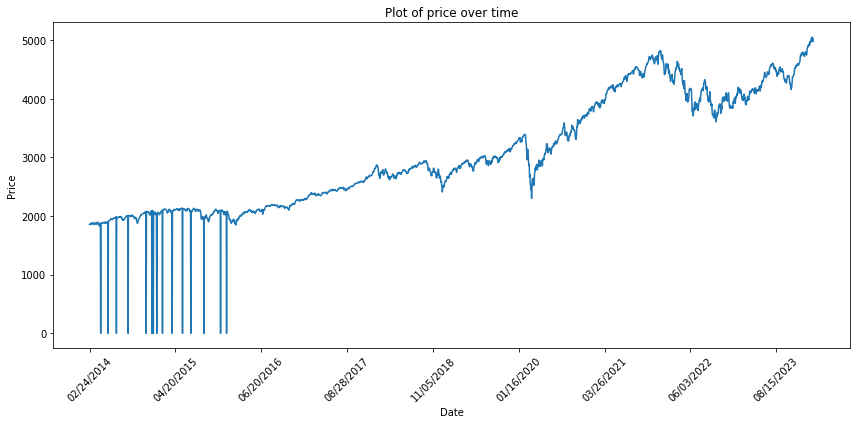

In [22]:
plot_chart(df, ["High"])

In [33]:
#remove data before june 2016
df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[df['Date'] >= '06/01/2016']
df_filtered = df_filtered.reset_index(drop=True)

df_filtered.head()

,Date,Close/Last,Open,High,Low
0,2016-06-01,2099.33,2093.94,2100.97,2085.10
1,2016-06-02,2105.26,2097.71,2105.26,2088.59
2,2016-06-03,2099.13,2104.07,2104.07,2085.36
3,2016-06-06,2109.41,2100.83,2113.36,2100.83
4,2016-06-07,2112.13,2110.18,2119.22,2110.18


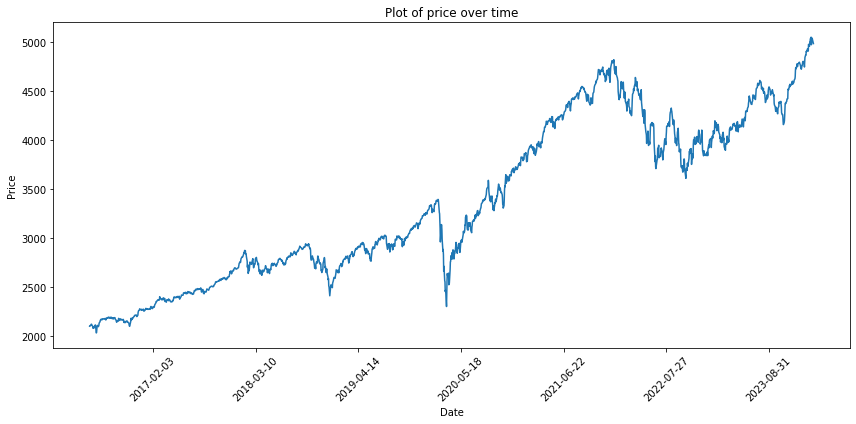

In [34]:
plot_chart(df_filtered, ["High"])

### 1. Linear Regression

In [25]:
#Technique 1: Linear Regression
#fit model to the last X (Hyperparam) days
#use model to predict price on day X+1
#eval

In [35]:
#fit model

def fit_lin_reg(X):
    model = LinearRegression()

    stock_prices = df_filtered["High"].values
    predicted_stock_prices = [0] * X

    for ind, _ in enumerate(stock_prices): #loop over daily highs
        if ind >= len(stock_prices) - X:
            break
        prices = stock_prices[ind:ind + X] #get X highs (label)
        days = np.arange(X).reshape(-1, 1) #X days (feature)
        model.fit(days, prices) #fit model to training examples
        y_pred = model.predict(np.array(X + 1).reshape(-1, 1)) #predict on day X+1
        predicted_stock_prices.append(round(y_pred[0], 2)) 

    predicted_stock_prices = np.array(predicted_stock_prices)
    df_filtered_ext = df_filtered.copy()
    df_filtered_ext["lin_reg_pred"] = predicted_stock_prices
    return df_filtered_ext

df_filtered_ext = fit_lin_reg(5)

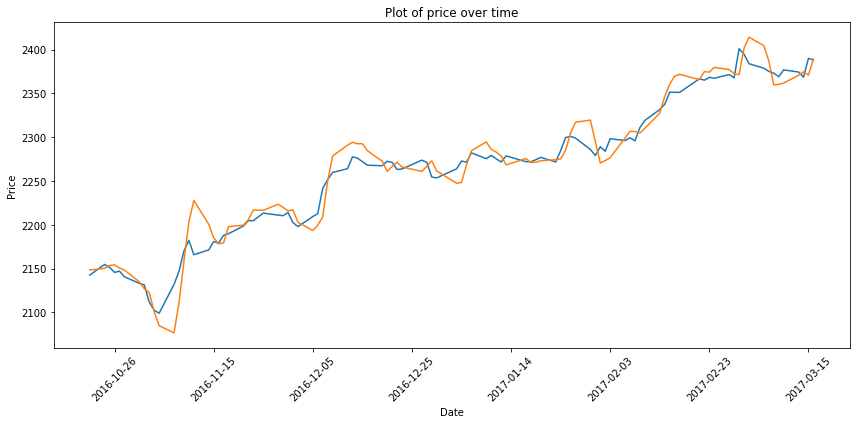

In [36]:
#plot
plot_chart(df_filtered_ext[100:200], ["High", "lin_reg_pred"])

In [37]:
#eval

#print(df_filtered_ext["High"][X:])
#print(df_filtered_ext["lin_reg_pred"][X:])
errors = []

for X in tqdm(range(1,20)):
    df_filtered_ext = fit_lin_reg(X)
    mse = np.mean((df_filtered_ext["High"][X:] - df_filtered_ext["lin_reg_pred"][X:]) ** 2)
    errors.append(mse)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Lowest MSE is 960.7744060730826, with X=1 (just copies high from prev day)
Lowest MSE is 2472.6941750258, with non-trivial X=5


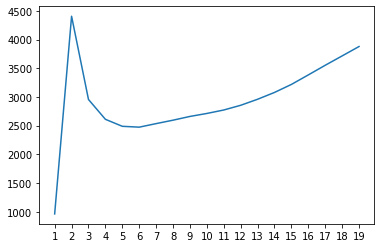

In [38]:
x_values = np.arange(1, len(errors) + 1)
plt.plot(x_values, errors)
plt.xticks(np.arange(1, len(errors) + 1, 1))

best_X, best_MSE = min(enumerate(errors), key=lambda x: x[1])
print(f"Lowest MSE is {best_MSE}, with X={best_X+1} (just copies high from prev day)")

errors_copy = errors.copy()

del errors_copy[best_X]

sec_best_X, sec_best_MSE = min(enumerate(errors_copy), key=lambda x: x[1])
print(f"Lowest MSE is {sec_best_MSE}, with non-trivial X={sec_best_X+1}")

Can I find a method that is better than just copying the value from the previous day?

### 2. Multilayer Perceptron

In [171]:
# prepare training data

FEATURE_VEC_LEN = 3

features = []
labels = []
df_len = len(df_filtered_ext.values)


for ind in range(df_len):
    feature_vec = []
    if ind < df_len - FEATURE_VEC_LEN:
        for ind2 in range(FEATURE_VEC_LEN):
            feature = df_filtered_ext.loc[ind + ind2]["High"]
            feature_vec.append(feature)

        label = df_filtered_ext.loc[ind + ind2 + 1]["High"]
        labels.append(label)
        features.append(feature_vec)

features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)

# Shuffle only the training set
shuffle_indices = np.arange(len(X_train))
np.random.shuffle(shuffle_indices)

X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]


feature_scaler = StandardScaler()
label_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = label_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = label_scaler.transform(y_test.reshape(-1, 1))


In [172]:
# init model

model = Sequential()
model.add(Dense(units=8, input_dim=FEATURE_VEC_LEN, activation='relu'))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [173]:
# training

history = model.fit(X_train_scaled, y_train_scaled, epochs=25, batch_size=1, verbose=1)

Epoch 1/25
1552/1552 [==============================] - 4s 2ms/step - loss: 0.1724
Epoch 2/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0324
Epoch 3/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0092
Epoch 4/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0040
Epoch 5/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0029
Epoch 6/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0025
Epoch 7/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0024
Epoch 8/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0022
Epoch 9/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0022
Epoch 10/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 11/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 12/25
1552/1552 [==============================] - 3s 2ms/step - loss: 0.0020
E

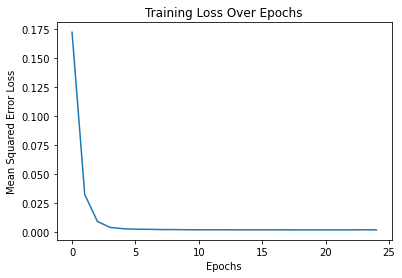

In [174]:
# training loss plotting
training_loss = history.history["loss"]
plt.plot(training_loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.show()

In [175]:
# eval

y_pred_scaled = model.predict(X_test_scaled)

y_pred = label_scaler.inverse_transform(y_pred_scaled)
y_test = label_scaler.inverse_transform(y_test_scaled)

mean_bias = np.mean(y_test - y_pred)

y_pred += mean_bias

#not possible because if i want to predict for day X+1, i need the actual value for day X+1, predict with 
#that day X+2 and take this prediction as the prediction for day X+1
#y_pred = y_pred[1:]
#y_test = y_test[:-1] 

mse = mean_squared_error(y_test, y_pred)

print(mse)

13/13 [==============================] - 0s 2ms/step
18.04529574392946


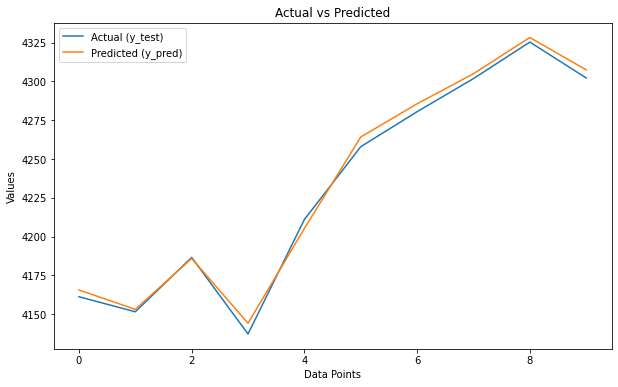

In [177]:
# Plot y_test and y_pred with a larger chart size
plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.plot(y_test[:10], label='Actual (y_test)')
plt.plot(y_pred[:10], label='Predicted (y_pred)')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.show()

In [139]:
print(X_test)
print(y_pred)
#print(model.predict(np.array([1.234,1.324,1.523])))

[[4144.95 4140.47 4167.66]
 [4140.47 4167.66 4161.29]
 [4167.66 4161.29 4151.58]
 ...
 [4971.3  5002.52 5032.72]
 [5002.52 5032.72 5038.7 ]
 [5032.72 5038.7  4993.71]]
[[4214.509 ]
 [4206.964 ]
 [4199.5957]
 [4234.0356]
 [4183.459 ]
 [4260.4683]
 [4300.5845]
 [4326.65  ]
 [4350.354 ]
 [4374.4575]
 [4352.425 ]
 [4345.4165]
 [4318.18  ]
 [4248.0854]
 [4213.7583]
 [4206.573 ]
 [4247.489 ]
 [4248.215 ]
 [4113.1655]
 [4098.9087]
 [4061.4954]
 [4016.647 ]
 [4063.579 ]
 [3983.7458]
 [4034.6165]
 [4049.8079]
 [4117.79  ]
 [4159.086 ]
 [4081.428 ]
 [4013.1736]
 [4006.9558]
 [3924.3843]
 [3946.0957]
 [3915.5767]
 [3948.491 ]
 [3831.0078]
 [3769.8645]
 [3756.69  ]
 [3754.24  ]
 [3772.2898]
 [3722.6992]
 [3710.447 ]
 [3733.884 ]
 [3820.6697]
 [3831.8738]
 [3835.203 ]
 [3746.6306]
 [3690.0483]
 [3679.0671]
 [3643.5667]
 [3719.875 ]
 [3735.0408]
 [3723.8733]
 [3798.676 ]
 [3760.7864]
 [3774.6384]
 [3793.474 ]
 [3845.4177]
 [3894.3494]
 [3921.7178]
 [3898.8914]
 [3946.3635]
 [3931.3506]
 [3952.9065]
